# Time Series Analysis
## Eric Feigelson 
## Summer School in Statistics for Astronomers

**This R-based tutorial shows a variety of time, frequency and wavelet domain methods applied to two very different datasets: a continuous signal of brightness in the X-ray band from an accretion disk in a Galactic stellar binary system; a continuous signal of brightness in the visible band from ordinary main sequence stars.  We do not consider here techniques for sparse, irregularly spaced lightcurves because they are treated by relatively few time series methods in R/CRAN.**  

We use the terms _time series_ (from statistics) and _light curve_ (from astronomy) interchangeably.

Some of this material appears in Chpt 11 of _Modern Statistical Methods for Astronomy with R Applications_, E.D.Feigelson & G.J. Babu 2012, henceforth _MSMA_.

# I The X-ray binary system GX 5-1
</br>
<center><img title="X-ray binary system" alt="X-ray binary system" src="Accretion_disk.jpg"></center>

GX 5-1 is a close binary system X-ray binary star system residing near the Galactic Center where gas from a normal companion is accreting (pulled) onto a neutron star through a differentially rotating accretion disk.  Highly variable X-rays are produced in the inner accretion disk, shown in blue in the above artist's drawing.  The X-ray variability often shows multiple components: Gaussian white noise; stochastic red noise; and quasi-periodic oscillations.  The first component is expected from photon counting statistics, but the latter components arise in the disk from uncertain physical processes. Hundreds of studies over 4 decades have been written about the variability of these X-ray binary systems.  The time series analysis is most often conducted in frequency domain with Fourier analysis.

The dataset at hand, called _GX.dat_ described in _MSMA_ Appendix C, has 65,536 measurements of X-ray photon counts in equally spaced 1/128-second bins.  They were obtained with the Japanese Ginga satellite during the 1980s. Although a Poisson process, the count rates are sufficiently high that they can be approximated by a Gaussian process. 

We first explore the dataset in a variety of displays.  A lightcurve plot superficially looks like Gaussian white noise, but the histogram of counts in each bin shows that the variance is 24% larger than expected from a white noise process, and asymmetry about the mean is present. 

Examination of the time series in its raw form and after various smoothing operations does not reveal obvious nonstationary structure to account for the extra variance, although some of the smoothers give a hint of autocorrelated variations with a characteristic time-scale around 20-50 seconds.   GX 5-1 thus appears to exhibit low-amplitude stochastic variability.

 num [1:65536] 79 70 68 58 50 59 52 55 61 64 ...


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.00   62.00   69.00   68.82   76.00  116.00 

 Time-Series [1:65536] from -0.992 to 65534: 79 70 68 58 50 59 52 55 61 64 ...


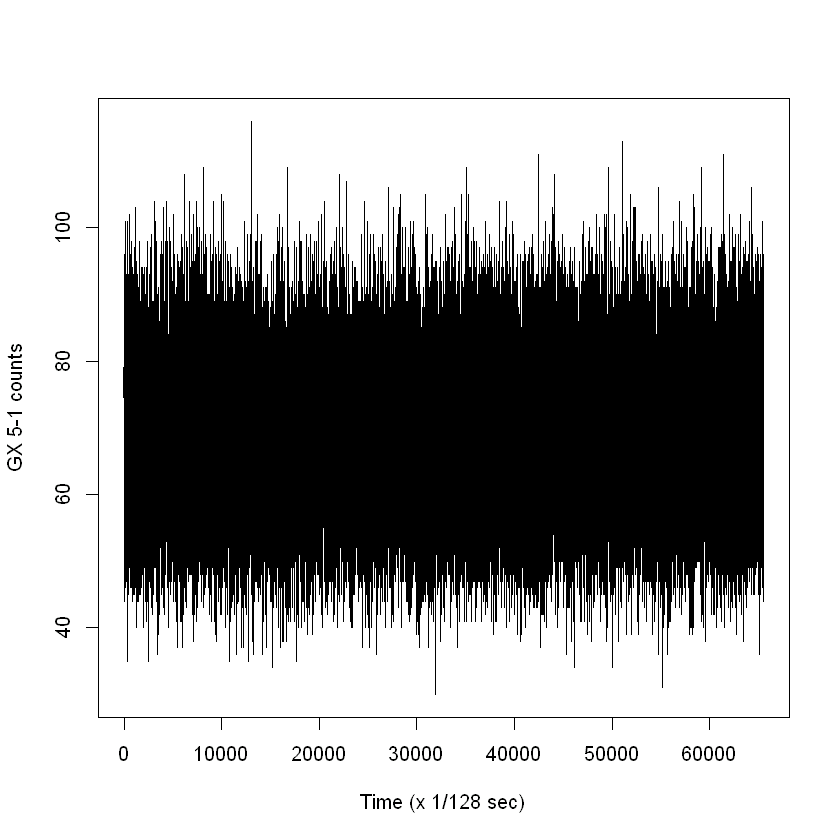

In [2]:
# Read the dataset

GX.dat <- scan("GX.dat") 
str(GX.dat)
summary(GX.dat)

# Convert to a class 'ts' (time series) R object

GX.time <- seq(from=0, to=512, length.out=length(GX.dat))
GX.ts <-  ts(GX.dat, GX.time) ; GX.ts.offset <- ts(GX.dat-30, GX.time)
str(GX.ts)

plot.ts(GX.ts, ylab='GX 5-1 counts', xlab='Time (x 1/128 sec)', 
   cex.lab=1.3, cex.axis=1.3, lwd=0.5)

[1] 1.241755

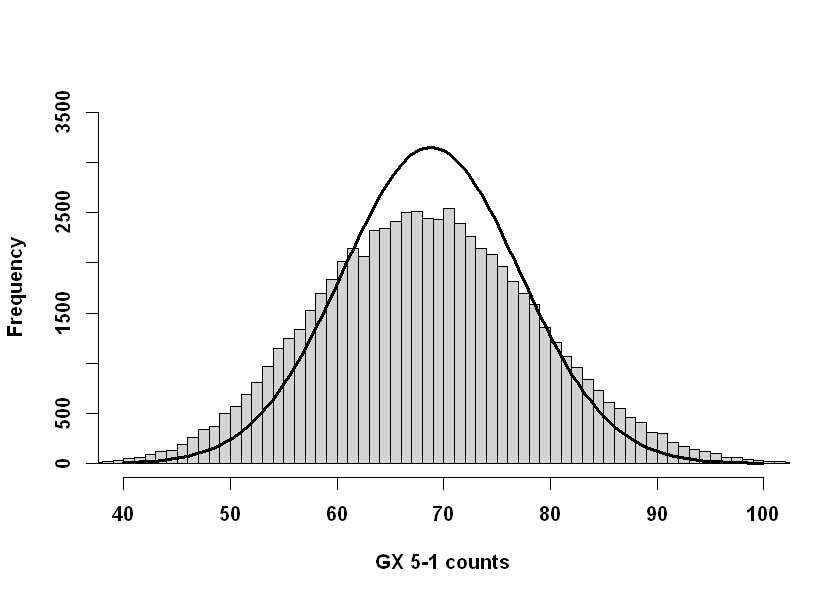

In [3]:
# Compare histogram of counts to normal distribution

options(jupyter.plot_scale=1)
options(repr.plot.width = 7, repr.plot.height = 5)

hist(GX.dat, breaks=100, xlim=c(40,100), ylim=c(0,3500), xlab='GX 5-1 counts',
   font=2, font.lab=2, main='')
curve(dnorm(x,mean=mean(GX.dat), sd=sqrt(mean(GX.dat)))*65536, lwd=3, add=T)
sd(GX.dat) / sqrt(mean(GX.dat))  # counts are 1.24 x overdispersed compared to Gaussian noise

We now inquire into the cause of this overdispersion.  First we look at an expanded light curve of the first ~10% of the dataset.  There are hints of faint wiggles.  Next we subject the full lightcurve to several smoothing algorithms: kernel density estimation with a Gaussian kernel; moving average smoother; a modified Daniell smoother (a weighted moving average widely used in time series analysis); Jerome Friedman's _super-smoother_  local regression with adaptive bandwidths; and Cleveland's _LOWESS_ robust local polynomial regression.  Third, we plot the nonparametric autocorrelation function (ACF) and partial ACF of the time series. 

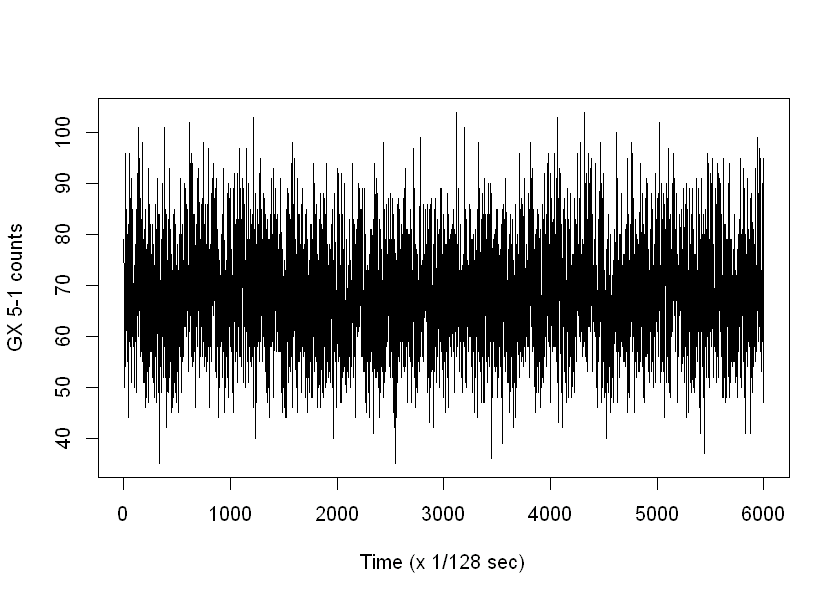

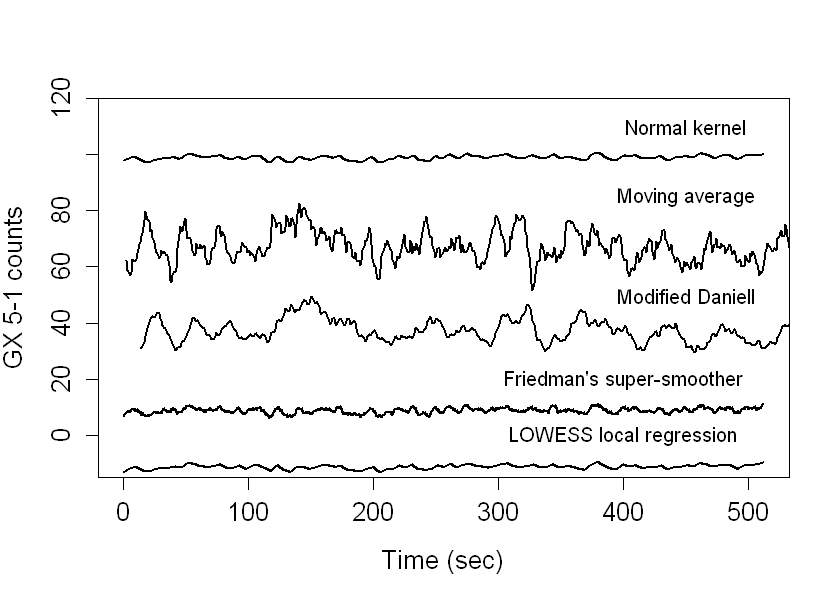

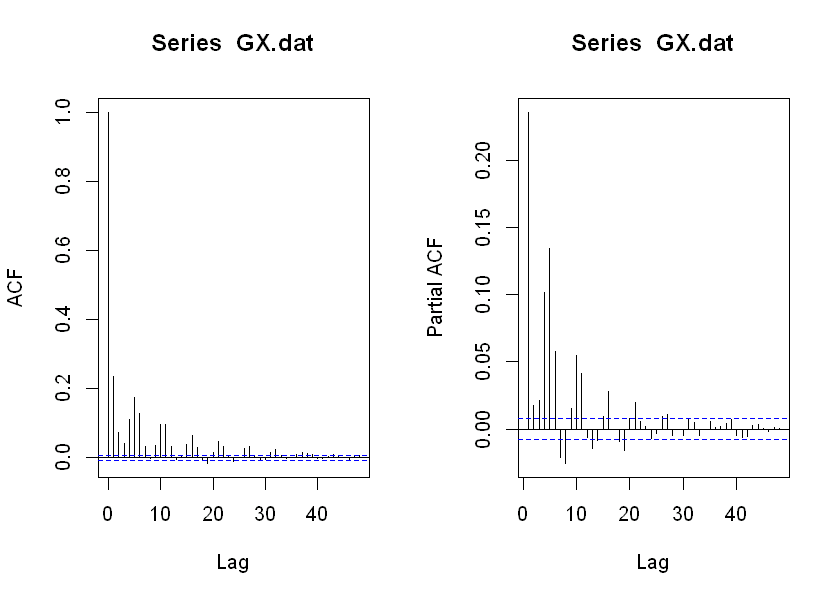

In [4]:
plot.ts(GX.ts[1:6000], ylab='GX 5-1 counts', xlab='Time (x 1/128 sec)', 
   cex.lab=1.3, cex.axis=1.3)  # Close-up view of 10% of the data

plot(GX.time,GX.dat, ylim=c(-10,115), xlab='Time (sec)', ylab='GX 5-1 counts',
   cex.lab=1.3, cex.axis=1.3, type='n')  # set up plot window but don't show any data
lines(ksmooth(GX.time, GX.dat+30, 'normal', bandwidth=7), lwd=2) 
text(450, 110, 'Normal kernel')  # Gaussian kernel density estimator with 7 bin FWHM bandwidth
lines(filter(GX.ts, sides=2, rep(1,7)/7), lwd=2) 
text(450, 85, 'Moving average') # Moving average smoother with 7 bin bandwidth
lines(kernapply(GX.ts.offset, kernel('modified.daniell', 7)), lwd=2) 
text(450, 50, 'Modified Daniell')  # Moving average smoother with 1/2-weight at the end values of the span
lines(supsmu(GX.time, GX.dat-60, span=0.01), lwd=2) 
text(400, 20, "Friedman's super-smoother") # A smoother with adaptive bandwidth from Friedman (1984)
lines(lowess(GX.time, GX.dat-80, 0.02), lwd=2) 
text(400, 0, 'LOWESS local regression') # Cleveland's (1979) robust local polynomial smoother

par(mfrow=c(1,2))
acf(GX.dat)
pacf(GX.dat)
par(mfrow=c(1,1))

Visual inspection of the raw lightcurve shows some faint wave-like behavior on scales of 10-20 seconds.  Some (but not all) of the smoothed lightcurves show repeated peaks on scales of 20-40 seconds. It is not clear whether any of these are statistically significant.

The ACF and PACF give a much clearer view of the short-memory behavior.  The serial autocorrelation (lag=1) exceeds 20% showing strong dependence of current values on the previous values.  A quasi-periodic component with $P \sim 0.6$ seconds (lag=5) is seen.  And most importantly, the ACF shows that the structure is statistically signifcant (exceeds the 95% confidence intervals shown by the dashed lines) out to lag~30.  

> **Exercise 1.**  Examine the autocorrelation functions of different smoothed estimators of the GX 5-1 lightcurve.  How does the ACF respond to different smoother bandwidths?

Most astronomical treatments of quasi-periodic X-ray sources are based on Fourier spectral analysis.  Here we start with the classical Schuster periodogram using R's *spec.pgram* function.  We then proceed to experiment with various smoothers and tapers to reduce the variance of the raw periodogram.  Tapers have little effect in this case; they are more important for shorter datasets.  Smoothing, however, has a dramatic effect in reducing noise in the periodogram revealing structure from two distinct processes: a noise component below frequency $\sim$0.05 rising towards lower frequencies, and a broadened spectral peak around 0.17-0.23.   These are the red noise and quasi-periodic oscillations widely discussed in the literature [(van der Klis 1989)](https://ui.adsabs.harvard.edu/abs/1989ARA%26A..27..517V/abstract).

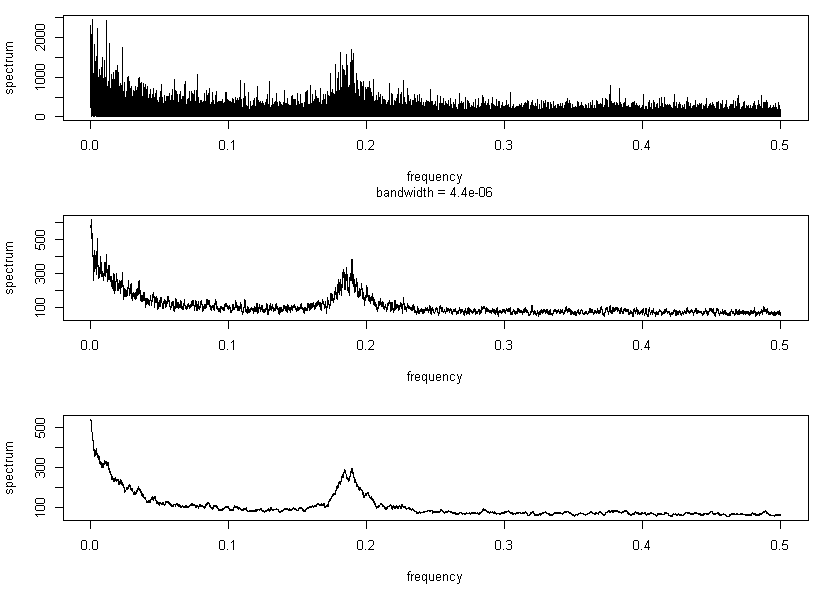

In [5]:
# Spectral periodogram

par(mfrow=c(3,1))  ;  par(mar=c(5,4,1,2))
spec.pgram(GX.ts, log='no', main='')
spec.pgram(GX.ts, spans=50, log='no', main='', sub='')
spec.pgram(GX.ts, spans=200, taper=0.15, log='no', main='', sub='')

> **Exercise 2:** Examine the effects of different tapers and smoothing of this Fourier periodogram. Try CRAN package _multitaper_ for a more modern approach to tapering.  

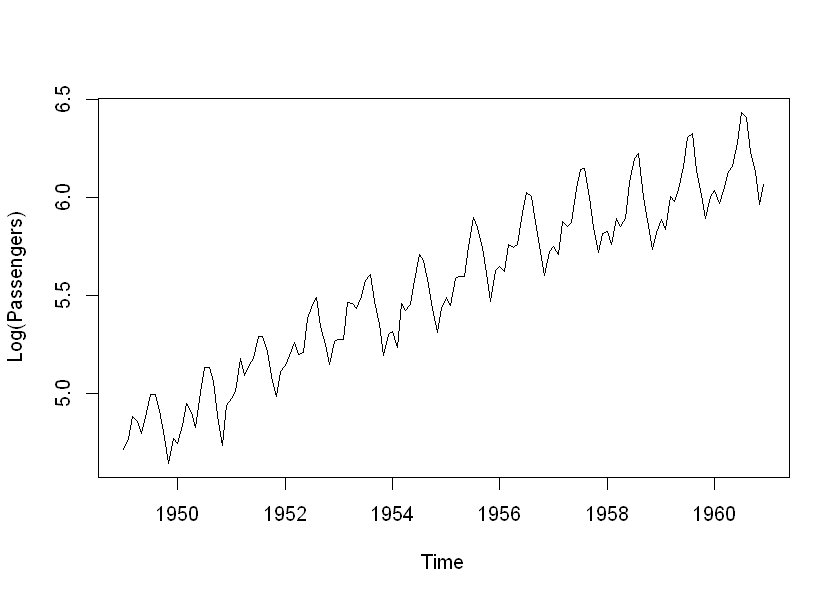

In [16]:
# Exc 2 soln
# For our soln, we shall use the exemplar dataset of AirPassengers

library(forecast)

data("AirPassengers")
ts_data <- log(AirPassengers)

plot.ts(ts_data, ylab='Log(Passengers)', xlab='Time', 
        cex.lab=1.3, cex.axis=1.3, lwd=0.5)

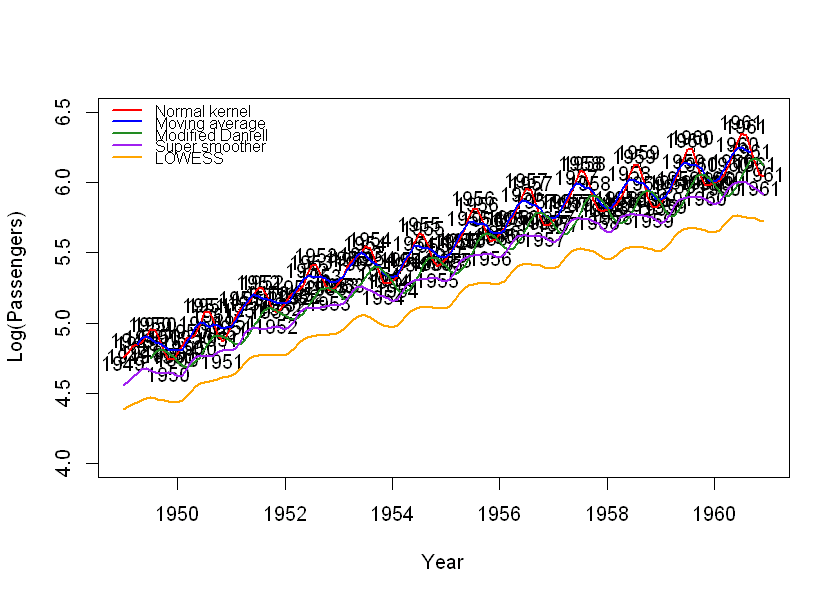

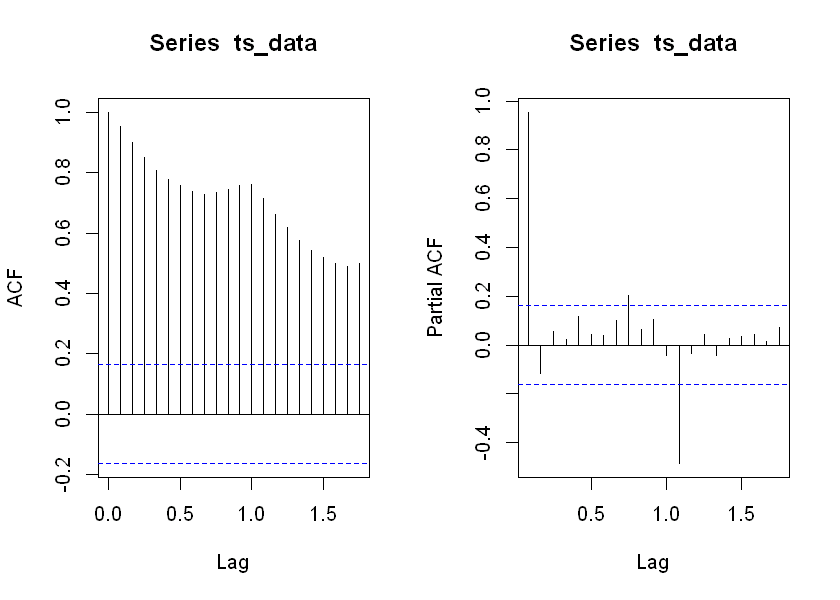

In [23]:
# Load and transform data
data("AirPassengers")
ts_data <- log(AirPassengers)
time <- time(ts_data)

# Setup plot window (suppress axis labels)
plot(time, ts_data, ylim=c(4, 6.5), xlab='Year', ylab='Log(Passengers)',
     cex.lab=1.3, cex.axis=1.3, type='n')

# Add smoothed curves
lines(ksmooth(time, ts_data, kernel="normal", bandwidth=0.25), lwd=2, col="red")
lines(filter(ts_data, sides=2, rep(1,7)/7), lwd=2, col="blue")
lines(kernapply(ts_data - 0.1, kernel("modified.daniell", 3)), lwd=2, col="forestgreen")
lines(supsmu(time, ts_data - 0.2, span=0.05), lwd=2, col="purple")
lines(lowess(time, ts_data - 0.4, f=0.1), lwd=2, col="orange")

# Add legend
legend("topleft", legend=c("Normal kernel", "Moving average", 
                           "Modified Daniell", "Super smoother", "LOWESS"),
       col=c("red", "blue", "forestgreen", "purple", "orange"), lwd=2, cex=0.8,
       bty="n")  # bty="n" removes box

# Optionally re-add border box
box()

# ACF and PACF plots unchanged
par(mfrow=c(1,2))
acf(ts_data)
pacf(ts_data)
par(mfrow=c(1,1))


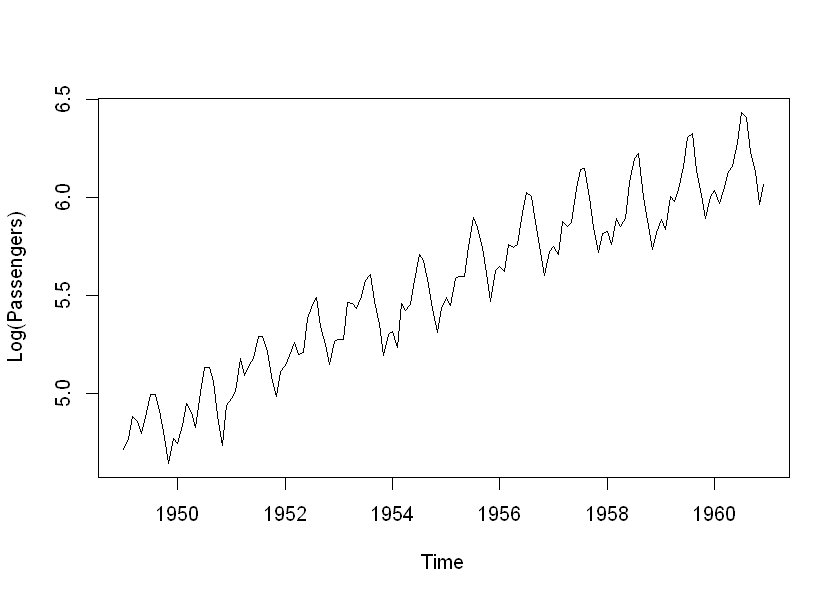

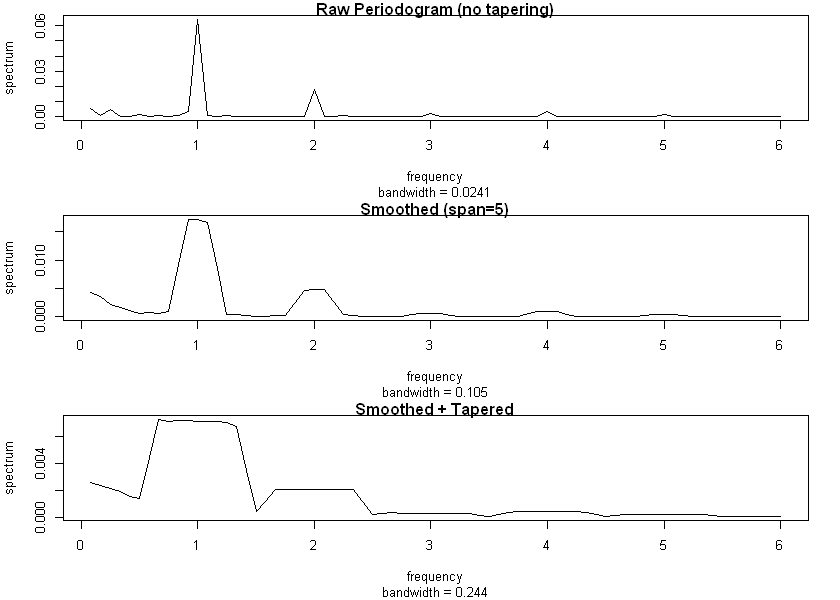

In [14]:
par(mfrow=c(3,1))  ;  par(mar=c(5,4,1,2))

spec.pgram(ts_data, log='no', main='Raw Periodogram (no tapering)')
spec.pgram(ts_data, spans=5, log='no', main='Smoothed (span=5)')
spec.pgram(ts_data, spans=10, taper=0.15, log='no', main='Smoothed + Tapered')

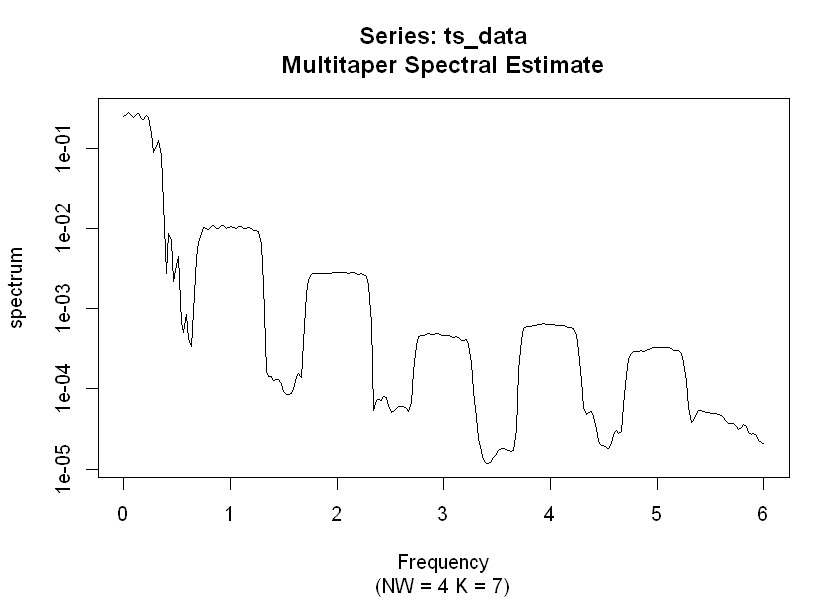

In [15]:
library(multitaper)
spec.mtm(ts_data, nw = 4, k = 7, returnInternals = TRUE, plot = TRUE)

Statisticians typically treat stochastic variability with autoregressive models such as ARMA (stationary short-memory), ARIMA (with nonstationary trends), ARFIMA (with long-memory $1/f^\alpha$ red noise), GARCH (with volatility), and other variations such as PAR (Poisson autoregressive). These models are fit by maximum likelihood estimation, giving a unique best fit once the model type and number of parameters is chosen.  Model selection between model types and complexity (order) within a model type is obtained by optimizing the Akaike Information Criterion (similar to the Bayesian Information Criterion). The residuals of the best fit model are then examined with a variety of tests; model development ends when the residuals are close to Gaussian white noise.  

The function _ar_ in base-R fits a simple model with just an autoregressive component where the current flux value depends on previous flux values. The best-fit model has 27 coefficients.  The AR(27) fit is quite good: the model's spectral density (obtained with _spec.ar_) nicely shows the red noise and QSO in the observed spectral density.   Goodness-of-fit tests on the AR(27) model residuals shows an excellent ACF and they satisfy the Ljung-Box hypothesis test for white noise, although the residuals still have a non-Gaussian distribution as measured with the Anderson-Darling test.  We could stop here, but a model with 27 coefficients is not very parsimonious model. A multicomponent model might be simpler and tell us more about the underlying behavior. 

package 'goftest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Time27.B1729\AppData\Local\Temp\Rtmpsvxbpe\downloaded_packages

Call:
ar(x = GX.ts, method = "ols")

Coefficients:
      1        2        3        4        5        6        7        8  
 0.2047   0.0153   0.0046   0.0674   0.1086   0.0515  -0.0166  -0.0242  
      9       10       11       12       13       14       15       16  
 0.0059   0.0430   0.0370  -0.0053  -0.0097  -0.0073   0.0032   0.0241  
     17       18       19       20       21       22       23       24  
-0.0010  -0.0064  -0.0167   0.0040   0.0177   0.0034   0.0025  -0.0067  
     25       26       27  
-0.0050   0.0073   0.0113  

Intercept: -4.655e-05 (0.03832) 

Order selected 27  sigma^2 estimated as  96.18


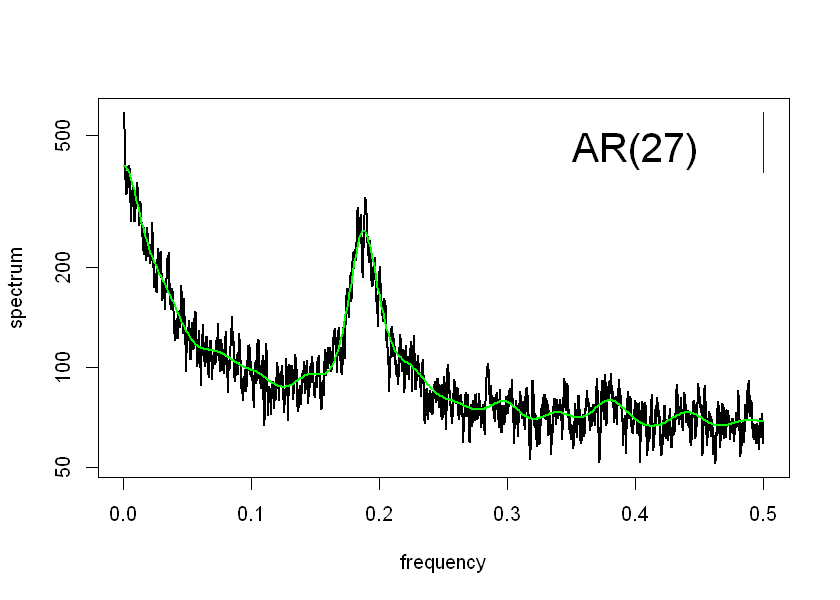


	Box-Ljung test

data:  ARmod$resid
X-squared = 0.00016918, df = 1, p-value = 0.9896



	Anderson-Darling test of goodness-of-fit
	Null hypothesis: uniform distribution
	Parameters assumed to be fixed

data:  na.omit(ARmod$resid)
An = Inf, p-value = 9.159e-09


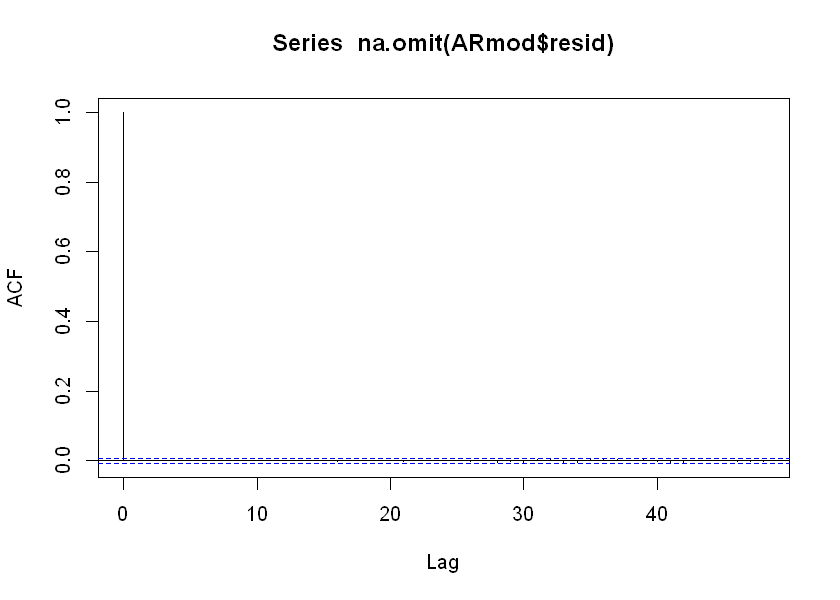

In [24]:
# Autoregressive modeling: AR

if(!require("goftest", quietly=T)) {
  install.packages("goftest", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(goftest)
ARmod <- ar(GX.ts, method='ols') 
print(ARmod)

ARspec <- spec.ar(GX.ts, plot=F)
GXspec <- spec.pgram(GX.ts, span=101, main='', sub='', lwd=2)
lines(ARspec$freq, ARspec$spec, col='green', lwd=2)
text(0.4,450, cex=2, paste0('AR(', ARmod$order, ')'))

acf(na.omit(ARmod$resid))
Box.test(ARmod$resid, type='Ljung')  # test for autocorrelation in AR residuals
library(goftest)
ad.test(na.omit(ARmod$resid))  # test for normality in AR residuals

For more complex autoregressive models, we turn to the highly capable and popular _forecast_ CRAN package designed for econometrics [Hyndman & Athanosopoulos 2021](http://OTexts.com/fpp3). The _auto.arima_ best fit a simpler ARIMA(3,1,3) model with only 6 coefficients. But the fit is poor with significant autocorrelation in the residuals.  This is seen both through the ACF plot and in the probability of the Ljung-Box test.  

A nonlinear ARFIMA (autoregressive fractional integrated moving average) is mathematically equivalent to fitting a $1/f^\alpha$ long-memory component simultaneously with ARMA short-memory components, in addition to detrending via the differencing operator. The maximum likelihood best fit with AIC model selection has 8 components,  ARFIMA(5,0.187,2).  Now the residuals have no autocorrelation and the Ljung-Box test is satisfied.  Nonetheless, the fit is not perfect as the standard deviation of the residuals is only 5\% smaller than the original data and the residuals do not satisfy the Anderson-Darling test for Gaussianity.  The long-range coefficient $d=0.187$ is equivalent to $\alpha=0.374$ in the $1/f^\alpha$ formulation of the powerlaw component.

We have learned that an autoregressive process can explain most of the temporal behavior of GX 5-1, but the model is not very simple.  If one considers only AR behavior, then 27 model coefficients are needed. A low-dimensional linaer ARIMA model is inadequate but a nonlinear ARFIMA model with a 1/f-type 'red noise' component is reasonable satisfactory. Note that none of these models include a strictly periodic component. ARMA-type models often show quasi-periodic behaviors without the introduction of a sinusoidal-type periodicity.

Series: GX.ts 
ARIMA(1,1,1) 

Coefficients:
         ar1      ma1
      0.2132  -0.9844
s.e.  0.0045   0.0020

sigma^2 = 99.95:  log likelihood = -243875.7
AIC=487757.4   AICc=487757.4   BIC=487784.6

Training set error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set 0.00271149 9.997498 8.000906 -2.195801 12.08671 0.7866573
                      ACF1
Training set -5.352045e-05


	Box-Ljung test

data:  arima_fit$residuals
X-squared = 95.516, df = 1, p-value < 2.2e-16



Call:
  arfima(y = GX.ts) 

*** Warning during (fdcov) fit: unable to compute correlation matrix; maybe change 'h'

Coefficients:
       Estimate
d         0.187
ar.ar1    0.721
ar.ar2   -0.815
ar.ar3    0.004
ar.ar4    0.011
ar.ar5    0.026
ma.ma1    0.702
ma.ma2   -0.746
sigma[eps] = 9.815697 
[d.tol = 0.0001221, M = 100, h = 0.002557]
Log likelihood: -2.427e+05 ==> AIC = 485362.5 [9 deg.freedom]


	Box-Ljung test

data:  arfima_fit$residuals
X-squared = 0.0023008, df = 1, p-value = 0.9617


[1] 10.30129

[1] 9.814855

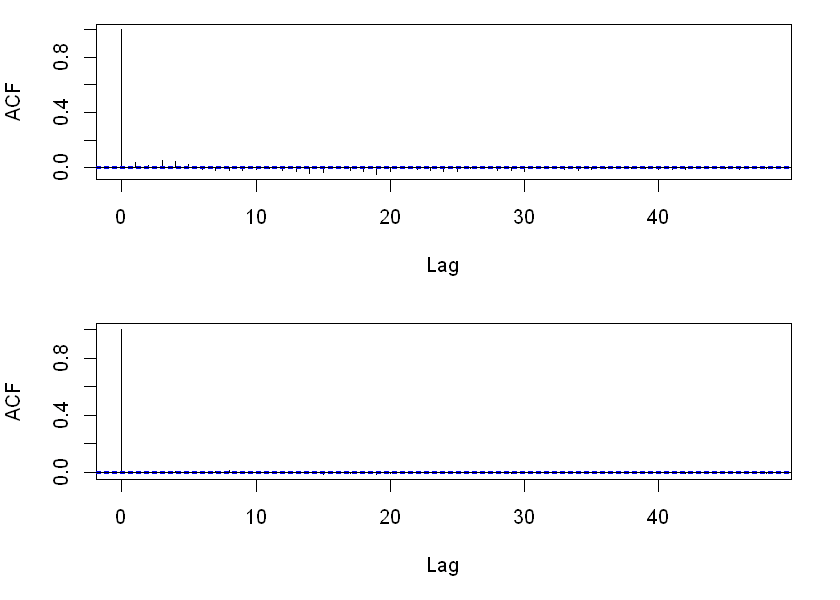

In [25]:
# Autoregressive modeling: ARIMA and ARFIMA

if(!require("forecast", quietly=T)) {
  install.packages("forecast", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(forecast)
ARIMA_fit <- auto.arima(GX.ts)
summary(ARIMA_fit)

par(mfrow=c(2,1))  ;  par(mar=c(5,4,1,2))
arima_fit <- auto.arima(GX.ts, stepwise=FALSE, approximation=FALSE, max.p=3, max.q=3, max.d=1)
acf(arima_fit$residuals)
Box.test(arima_fit$residuals, type='Ljung-Box')

arfima_fit <- arfima(GX.ts)
summary(arfima_fit)
acf(arfima_fit$residuals)
Box.test(arfima_fit$residuals, type='Ljung-Box')
sd(arfima_fit$x) ; sd(arfima_fit$residuals)


> **Exercise 3:** In econometric autoregressive modeling, models with strictly periodic components are called _SARIMA_ where S = seasonal.  Here the period must be specified in advance; this is not a period-searching algorithm.  Try adding a seasonal component to the GX 5-1 ARIMA model based on the peak of the QPO signal in ther periodogram.  Try the SARIMA implementation in CRAN package _astsa_; a tutorial appears [here](https://medium.com/@kfoofw/seasonal-lags-sarima-model-fa671a858729). 

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Series: GX.ts 
ARIMA(2,0,1)(1,0,1)[12] with non-zero mean 

Coefficients:
         ar1      ar2      ma1     sar1    sma1     mean
      1.0793  -0.1409  -0.8713  -0.5346  0.5363  68.8196
s.e.  0.0079   0.0048   0.0066      NaN     NaN   0.0811

sigma^2 = 98.75:  log likelihood = -243479.5
AIC=486973   AICc=486973   BIC=487036.6

Training set error measures:
                        ME     RMSE      MAE       MPE   MAPE      MASE
Training set -0.0001159765 9.936975 7.952084 -2.195497 12.016 0.7818571
                    ACF1
Training set 0.007236153

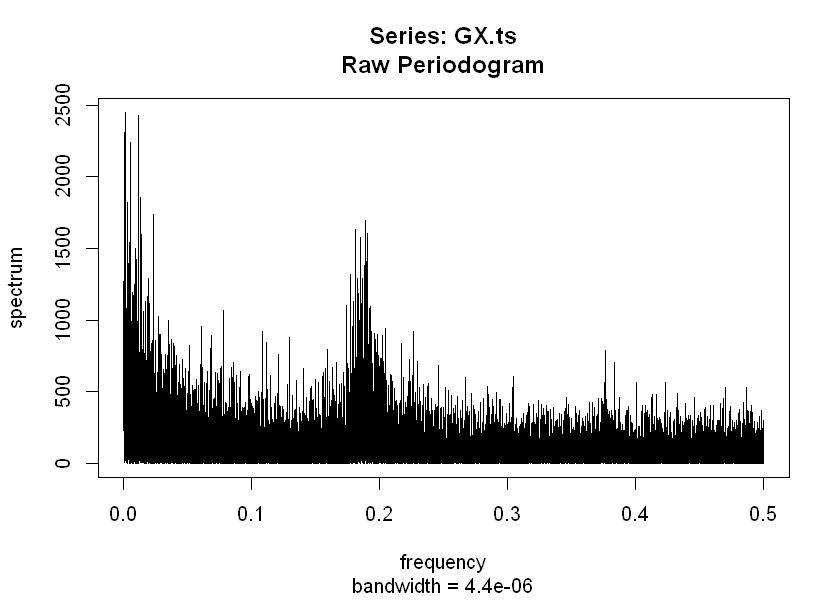

Series: GX.ts 
ARIMA(2,1,3) with drift 

Coefficients:
         ar1      ar2      ma1     ma2      ma3   drift
      0.5467  -0.7579  -1.3527  1.0698  -0.6203  0.0001
s.e.  0.0191   0.0169   0.0217  0.0353   0.0139  0.0031

sigma^2 = 99.4:  log likelihood = -243691
AIC=487396   AICc=487396   BIC=487459.6

ERROR: Error in arima(2, 0, 1): 'order' must be a non-negative numeric vector of length 3


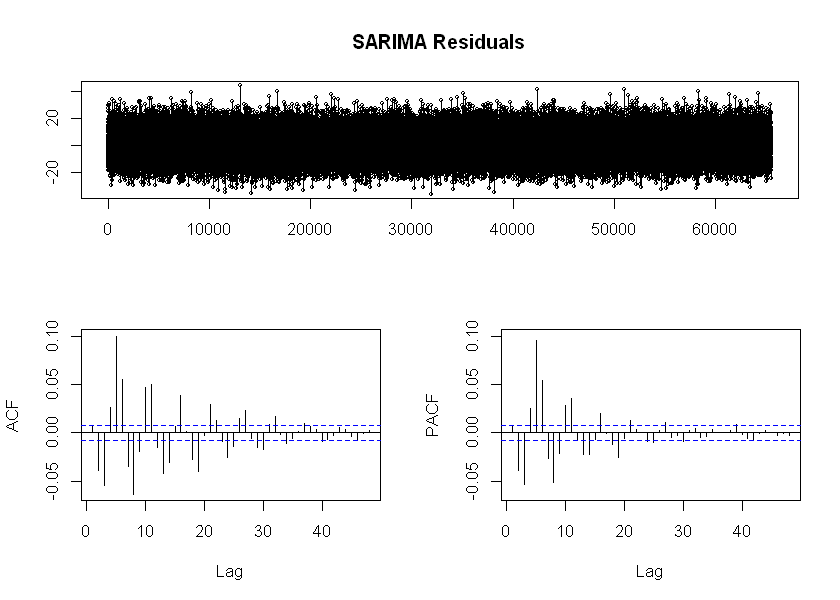

In [31]:
# Exc 3 soln
spec <- spec.pgram(GX.ts, log='no', plot=TRUE)

library(forecast)

# Fit SARIMA model with seasonal period = 12
fit_sarima <- Arima(GX.ts, order=c(2,0,1), seasonal=list(order=c(1,0,1), period=12))

# Summary of fit
summary(fit_sarima)

# Diagnostic plots
tsdisplay(residuals(fit_sarima), main="SARIMA Residuals")

auto.arima(GX.ts, seasonal=TRUE, stepwise=FALSE, approximation=FALSE)

arima(2,0,1)(1,0,1)[12]

autoplot(GX.ts) +
  autolayer(fitted(fit_sarima), series="Fitted SARIMA", color='red') +
  ggtitle("GX 5-1: Fitted SARIMA Model") +
  ylab("Counts") + xlab("Time")


The final challenge is to interpret the autoregressive results astrophysically in terms of X-ray emission from an accretion disk orbiting a compact star.  Can the red noise slope $\alpha=0.374$ and the 7 ARFIMA coefficients be related to turbulent or other processes in the disk? This probably requires ARMA-type modeling of time-dependent accretion disk models, which has not been performed.  See however the clever physical interpretation of a wavelet analysis of the accretion binary Sco X-1 by [Scargle et al. (1993)](https://ui.adsabs.harvard.edu/abs/1993ApJ...411L..91S/abstract).  

Altogether, we see that the temporal behavior of X-ray emission from accretion binaries is quite complex. GX 5-1 is actually simpler than some others: the black hole binary system GRS 1915+105 has a dozen distinct modes of X-ray variability that requires even more advanced statistical methods to characterize ([Belloni et a. 2000](https://ui.adsabs.harvard.edu/abs/2000A%26A...355..271B/abstract), [Huppenkothen et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466.2364H/abstract)).

> For further study related to this notebook, browse the on-line lecture notes from the Penn State courses STAT 510 [Applied Time Series Analysis](https://online.stat.psu.edu/stat510/) 

# II Stellar lightcurves from the Kepler mission

<center><img title="Kepler mission exoplanets" alt="Kepler mission exoplanets" src="Kepler_exoplanets.jpg"></center>

The Kepler mission measured the brightnesses in the visible band of $\sim$150,000 stars every 29.4 minutes for nearly 4 years with very high precision. The mission successfully detected several thousand cases where an exoplanet transited across the stellar disk, causing faint periodic dips. But the effort was complicated by the wide range in intrinsic stellar variability. We illustrate some time series methods for evenly spaced time series using two stars that have been preprocessed using the procedures of [Caceres et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....158...58C/abstract).  One star exhibits low level stochastic scatter characteristics of solar-type stars with low magnetic activity, and the other shows high levels of quasi-periodic variability from rotationally modulated starspots.
We do not attempt to detect transiting exoplanets in this tutorial.

Kepler time series have the advantage of being evenly spaced, but there are many time slots missing data (‘Not Available' or NA in R) due to satellite operations or instrumental problems. Many time series methods, including Fourier analysis, require that the data have real values at every evenly spaced time stamp. This often requires replacing missing data with estimated values; statisticians call this ‘imputation'. Several CRAN packages currently provide imputation procedure for time series including _Amelia_, _imputePSF_, _imputeTS_, and _mtsdi_. They implement a variety of imputation methods including: linear, spline and Stineman interpolation; moving average interpolation;
carrying forward last value; random sampling of all values; maximum likelihood or bootstrap assuming normal distributed values; generalized additive models using exogenous variables; interpolation based on ARIMA autoregressive models; forecasting based of pattern sequences; and interpolation based on Gaussian state-space models. 

First we examine the first Kepler lightcurve, KIC 007596240. The input data
here is a vector of 71,427 evenly spaced flux measurements of which 16% are missing
(NAs). The median is close to zero and the interquartile 
range is 6.5 flux units. 

To the eye, the lightcurve seems to consist of random noise
but the autocorrelation function shows statistically significant structure at both
long and short lag times. The histogram of values is nearly, but not
quite, Gaussian and an Anderson-Darling test for normality
shows that the discrepancy is statistically significant (P << 0.0001). Kendall's
$\tau$ nonparametric test shows a marginally significant global trend, but smoothing
show no evident patterns over a broad range of window widths. 

To reduce the
autocorrelation in the Kepler1 time series, we choose to fit an ARIMA model of
order (2,1,2). The autocorrelation function structure of the residuals is now mostly,
but not entirely removed.

[1] 0.1587215

[1] 0.2883783

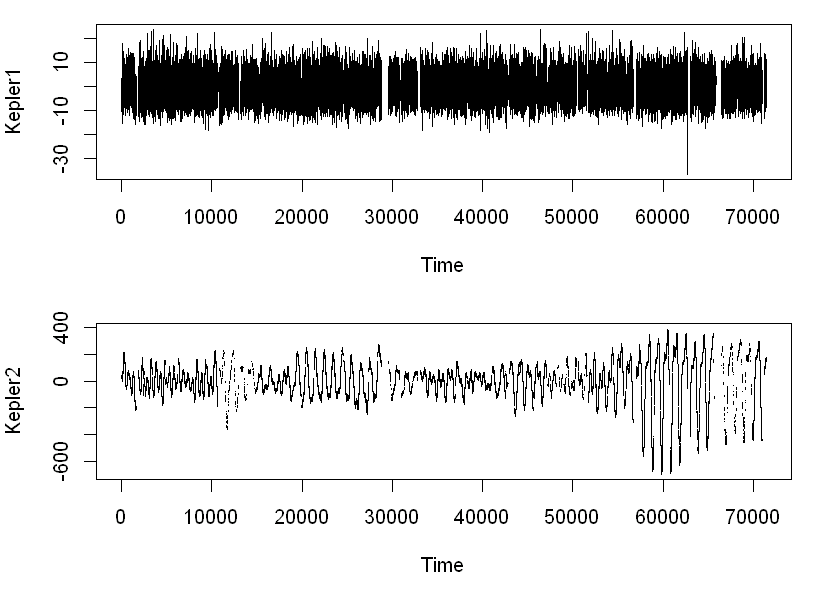

In [29]:
# Ingest and plot light curves for three Kepler stars

Kepler1 <- read.table('Kepler1.dat')[[1]] # KIC 007596240
Kepler2 <- read.table('Kepler2.dat')[[1]] # KIC 007609553

length(which(is.na(Kepler1))) / length(Kepler1) # 16% NAs
length(which(is.na(Kepler2))) / length(Kepler2) # 29% NAs

par(mfrow=c(2,1)) ; par(mar=c(5,4,1,2))
plot(Kepler1, type='l', xlab='Time')
plot(Kepler2, type='l', xlab='Time')

 Kepler 1: Median flux =  -0.2644167  with InterQuartile Range =  6.476321

Warning message:
"package 'MASS' was built under R version 4.4.3"


package 'nortest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Time27.B1729\AppData\Local\Temp\Rtmpsvxbpe\downloaded_packages



Attaching package: 'nortest'


The following objects are masked from 'package:goftest':

    ad.test, cvm.test





	Anderson-Darling normality test

data:  Kepler1
A = 13.393, p-value < 2.2e-16


[1] 0.4305633

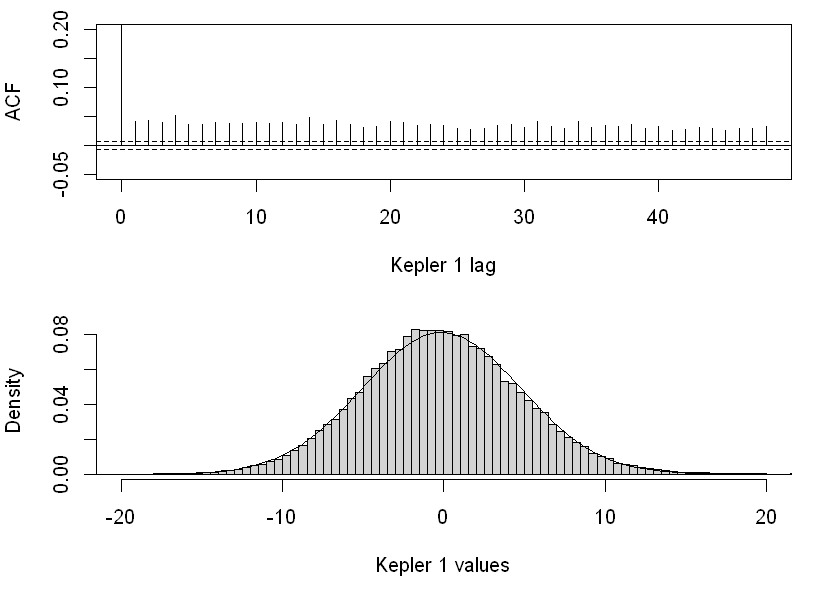

In [30]:
# Properties of the Kepler 1 lightcurve (KIC 007596240)

cat(' Kepler 1: Median flux = ', median(Kepler1, na.rm=TRUE), 
	' with InterQuartile Range = ', IQR(Kepler1, na.rm=TRUE))

par(mfrow=c(2,1)) ; par(mar=c(5,4,1,2))
acf(Kepler1, na.action=na.pass, ylim=c(-0.05, 0.2),
xlab='Kepler 1 lag', main='', ci.col='black')
hist(Kepler1, freq=FALSE, breaks=200, main='', xlim=c(-20,20),
xlab='Kepler 1 values')

library(MASS) # Comparison with normal distribution
Kep1_mn <- fitdistr(Kepler1[!is.na(Kepler1)], 'normal')[[1]][1]
Kep1_sd <- fitdistr(Kepler1[!is.na(Kepler1)], 'normal')[[1]][2]
curve(dnorm(x, Kep1_mn, Kep1_sd), -20, 20, add=TRUE)
if(!require("nortest", quietly=T)) {
  install.packages("nortest", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(nortest)
ad.test(Kepler1)

cor.test(1:length(Kepler1), Kepler1, method='kendall')$p.value # Test for trend


Call:
arima(x = Kepler1, order = c(2, 1, 2))

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


          ar1     ar2      ma1      ma2
      -0.3829  0.0045  -0.5975  -0.3775
s.e.      NaN     NaN      NaN      NaN

sigma^2 estimated as 23.6:  log likelihood = -180284.6,  aic = 360579.2
List of 14
 $ coef     : Named num [1:4] -0.38287 0.00453 -0.59755 -0.37753
  ..- attr(*, "names")= chr [1:4] "ar1" "ar2" "ma1" "ma2"
 $ sigma2   : num 23.6
 $ var.coef : num [1:4, 1:4] -0.51803 0.00326 0.51785 -0.50864 0.00326 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "ar1" "ar2" "ma1" "ma2"
  .. ..$ : chr [1:4] "ar1" "ar2" "ma1" "ma2"
 $ mask     : logi [1:4] TRUE TRUE TRUE TRUE
 $ loglik   : num -180285
 $ aic      : num 360579
 $ arma     : int [1:7] 2 2 0 0 1 1 0
 $ residuals: Time-Series [1:71427] from 1 to 71427: -0.00135 -0.1297 -6.64547 0.56856 NA ...
 $ call     : language arima(x = Kepler1, order = c(2, 1, 2))
 $ series   : chr "Kepler1"
 $ code     : int 0
 $ n.cond   : num 0
 $ nobs     : int 60089
 $ model    :List of 10
  ..$ phi  : num [1:2] -0.38287 0.00453
  .

[1] 6.476321

[1] 6.403205

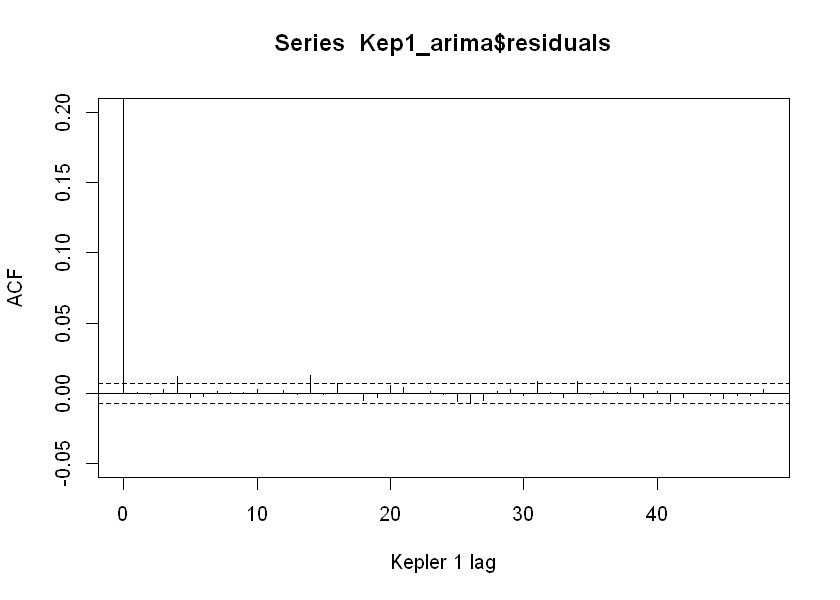

In [32]:
Kep1_arima <- arima(Kepler1, order=c(2,1,2)) # Autoregressive model
print(Kep1_arima)# look at a dummary of the 'arima' function output
str(Kep1_arima)  # look in detail at the 'arima' function output

acf(Kep1_arima$residuals, na.action=na.pass, ylim=c(-0.05, 0.2), xlab='Kepler 1 lag', ci.col='black')  # shows excellent improvement in autocorrelation ... 
IQR(Kepler1, na.rm=TRUE) ; IQR(Kep1_arima$residuals, na.rm=TRUE)  # ... but little improvement in noise

Some features of the R script above can be eludicated: 
1. The analysis is performed
entirely using base-R and packages embedded within it such as MASS and nortest.
2. We ingest light curves for two Kepler stars using read.table()[[1]] that coerces the data frame produced
by read.table into a vector. The unit of the Time variable is the Kepler
mission cadence of 29.4 minutes, and the full time series lasts almost 4 years.
3. Plotting parameters mfrow and mar set up the multi-panel format and margins, respectively.
4. The function is.na gives a vector of TRUE/FALSE logicals for Not Available elements.
Different R functions have different treatments of NAs (e.g., na.rm=TRUE
or na.action=na.pass to ignore missing values), and some functions will fail if any
NAs are present. 
5. The Gaussian fit to the unbinned Kepler1 values is performed
using the fitdistr function in the MASS library, and an Anderson-Darling nonparametric
goodness-of-fit test is performed using the ad.test function in the nortest
library. 
6. The scatter.smooth function is a convenient wrapper that computes and
plots a LOESS local regression smoother. 
7. The arima function is in the base-R stats
library, but other more elaborate codes can be found in CRAN packages such
as tseries and forecast. Some autoregressive modeling codes permit NAs but others
do not. 

We now apply a variety of time series diagnostics to the ARIMA residuals for KIC
007596240. CRAN packages implement a full suite of diagnostics for time series
modeling though the code is scattered throughout the R software environment:
1. CRAN package _nortest_ has the Anderson-Darling, Lilliefors (Kolmogorov-Smirnov), and other tests for  normality (Gaussianity).  
2. _base-R_ has the Shapiro-Wilk and Box-Pierce tests.  The latter has the option for the portmanteau Ljung-Box test which tells whether any autocorrelation is present out to a chosen lag time.  (The R code for Box.test is somewhat indirect because the
function requires that the vector of residuals has no missing values and lies within
a lm-class object produced by R's linear modeling function. So we impute
missing values and embed the residuals inside a fake lm object based on random numbers.)
3. CRAN _lmtest_ has the Durbin-Watson and Breusch-Godfrey tests for autocorrelation, but these are superseded by the Ljung-Box test.  
4. CRAN _tseries_ includes the runs, BDS test for i.i.d., KPSS tests and adjusted Dickey-Fuller test for stationarity(CPU intensive).  These are widely used in econometrics. 

The result of these calculations is that the ARIMA residuals for KIC 007596240
are inconsistent with normality and i.i.d., but exhibit little serial autocorrelation
and non-stationarity.

In [33]:
# Diagnostics tests on Kepler 1 ARIMA residuals

ad.test(Kep1_arima$residuals) # test for normality

if(!require("imputeTS", quietly=T)) {
  install.packages("imputeTS", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(imputeTS)
arima_resids <- na_kalman(Kep1_arima$residuals)
x <- 1:length(arima_resids) ; y <- rnorm(length(arima_resids))
lmobject <- lm(y ~ x)
lmobject$residuals <- arima_resids
Box.test(arima_resids, type='Ljung') # Ljung-Box test shows no autocorrelation in the ARIMA residuals


	Anderson-Darling normality test

data:  Kep1_arima$residuals
A = 14.803, p-value < 2.2e-16


also installing the dependencies 'sys', 'litedown', 'rappdirs', 'askpass', 'markdown', 'png', 'jpeg', 'diffobj', 'BH', 'timechange', 'cachem', 'memoise', 'mime', 'sass', 'openssl', 'gridtext', 'brio', 'praise', 'waldo', 'anytime', 'ellipsis', 'lubridate', 'bslib', 'fontawesome', 'jquerylib', 'tinytex', 'httr', 'ggtext', 'stinepack', 'testthat', 'R.rsp', 'timeSeries', 'tis', 'tsibble', 'rmarkdown', 'covr'




package 'sys' successfully unpacked and MD5 sums checked
package 'litedown' successfully unpacked and MD5 sums checked
package 'rappdirs' successfully unpacked and MD5 sums checked
package 'askpass' successfully unpacked and MD5 sums checked
package 'markdown' successfully unpacked and MD5 sums checked
package 'png' successfully unpacked and MD5 sums checked
package 'jpeg' successfully unpacked and MD5 sums checked
package 'diffobj' successfully unpacked and MD5 sums checked
package 'BH' successfully unpacked and MD5 sums checked
package 'timechange' successfully unpacked and MD5 sums checked
package 'cachem' successfully unpacked and MD5 sums checked
package 'memoise' successfully unpacked and MD5 sums checked
package 'mime' successfully unpacked and MD5 sums checked
package 'sass' successfully unpacked and MD5 sums checked
package 'openssl' successfully unpacked and MD5 sums checked
package 'gridtext' successfully unpacked and MD5 sums checked
package 'brio' successfully unpacked and

Warning message:
"package 'imputeTS' was built under R version 4.4.3"



	Box-Ljung test

data:  arima_resids
X-squared = 0.009737, df = 1, p-value = 0.9214


The second Kepler lightcurve (KIC 007609553) shows high amplitude variability
that is attributed to stellar rotation where the starlight is modulated as dark
starspots rotate in and out of view. Simple Fourier analysis can not be applied
because the periodicity changes phase as different spots grow and disappear on
timescales of months, the amplitude variation can have non-sinusoidal shape, and
the data stream has significant gaps.

We choose here to impute missing data using an ARIMA-based model from CRAN package _imputeTS_. This procedure does an impressive job at interpolating missing structure in the complicated quasi-periodic KIC 007609553 lightcurve.  The infilling of missing data is far better than can be achieved with naive procedures like linear interpolation.

Warning message in stats::StructTS(data, ...):
"possible convergence problem: 'optim' gave code = 52 and message 'ERROR: ABNORMAL_TERMINATION_IN_LNSRCH'"


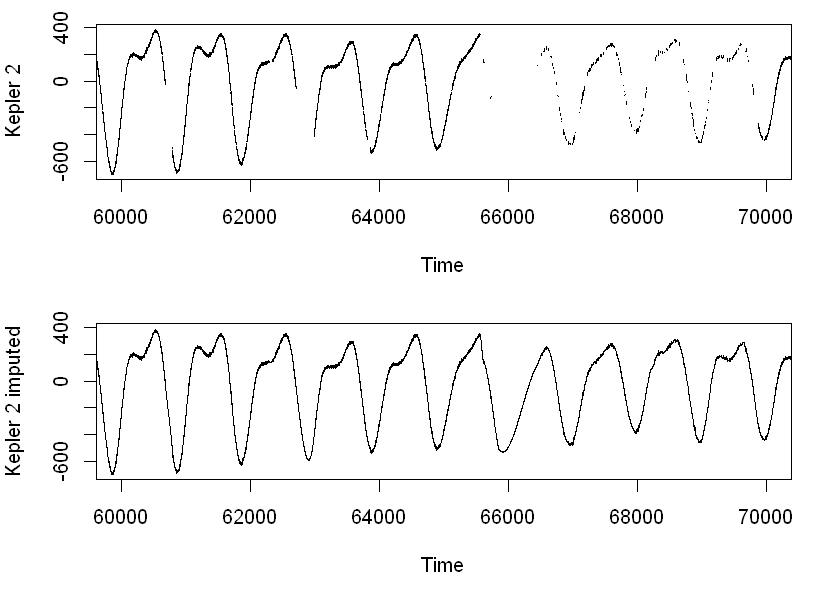

In [34]:
Kepler2_impute <- na_kalman(Kepler2) # impute NAs with Kalman smoother
par(mfrow=c(2,1)) ; par(mar=c(5,4,1,2))
plot(Kepler2, type='l', xlim=c(60000,70000), xlab='Time', ylab='Kepler 2')
plot(Kepler2_impute, type='l', xlim=c(60000,70000), xlab='Time',
ylab='Kepler 2 imputed')

We illustrate three spectral periodograms of the quasi-periodic KIC
007609553 lightcurve: 
1. Fourier analysis after imputation of missing values using
R's _spec.pgram_ function
2. The astronomers' least-squares Lomb-Scargle periodogram
available in CRAN packages _cts_ and _lomb_
3. One of several periodograms based on epoch folding and phase dispersion minimization in CRAN package _RobPer_.  The calculation may be a  bit slow. 

In this application, the Lomb-Scargle periodogram (LSP) has the best performance, as the Fourier spectrum shows low signal-to-noise (even after smoothing and tapering) and the PDM epoch folding procedure shows strong aliasing at low-frequency harmonics of the dominant period.  Note however that the LSP has known biases and inconsistencies ([Springford et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....159..205S/abstract)) and, after many years of debate, it is still unclear how to reliably evaluate the False Alarm Probabilities of LSP spectral peaks ([Koen 1990](https://ui.adsabs.harvard.edu/abs/1990ApJ...348..700K/abstract), [Baluev 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.385.1279B/abstract), [Suveges et al. 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.450.2052S/abstract), [Hara et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.1220H/abstract), [Sulis et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ITSP...65.2136S/abstract), [Delisle et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A..83D/abstract) and the review by [vanderPlas 2018](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract)).  There may be convergence on using the Generalized Extreme Value distribution, as recommended by Baluev, but the implementation can be complicated. 

In [0]:
# Three periodograms: Fourier, Lomb-Scargle, epoch folding

par(mfrow=c(3,1)) ; par(mar=c(5,4,1,2))
spec.pgram(Kepler2_impute, xlim=c(0,0.005), spans=5, taper=0.0,
main='', ylab='Fourier', sub='')

if(!require("lomb", quietly=T)) {
  install.packages("lomb", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(lomb)
lsp(Kepler2, from=0.00, to=0.005, ylab='Lomb-Scargle', main='')

if(!require("RobPer", quietly=T)) {
  install.packages("RobPer", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(RobPer)
Kepler2_temp <- cbind(1:length(Kepler2), Kepler2)
Kepler2_irreg <- Kepler2_temp[!is.na(Kepler2_temp[,2]),]
PDM_per <- seq(from=1, to=10001, length.out=1000)
Kepler_PDM <- RobPer(Kepler2_irreg, weighting=FALSE, regression='L2',
model='step', steps=10, periods=PDM_per)
PDM_freq <- 1/PDM_per
plot(PDM_freq, Kepler_PDM, type='l', xlab='frequency', ylab='PDM',
xlim=c(0,0.005))

> **Exercise 4.**  In CRAN package _lomb_, apply the function _randlsp_ that applies the Lomb-Scargle periodogram to random permutations of the flux values with the fixed irregular observation times.  This gives a primitive False Alarm Probability for the observed periodogram  peaks: if similar peak power appears in the permuted time series, then the periodicity is not significant.  However, it is dangerous to conclude that observed peaks exceeding those seen in permuted time series are always significant, as aperiodic structure (e.g. stochastic autoregressive behaviors) can interact with the cadence structure to produce false peaks.  

We end our examination with a wavelet decompositions
of the time series to assist in visualization of the variations at different
time-scales.We start with CRAN package waveslim to construct
the discrete wavelet transform using Mallat's pyramid algorithm and Daubechies'
orthonormal basis functions at ten different temporal scales. This package implements
a variety of wavelet methods for one-, two-, and three-dimensional data as
described in the volume by [Gencay et al. (2001)](https://www.elsevier.com/books/an-introduction-to-wavelets-and-other-filtering-methods-in-finance-and-economics/gencay/978-0-12-279670-8). We use the imputed lightcurve 
without data gaps, and truncate the lightcurve at 65536 time stamps to allow
rapid computation. 

The resulting wavelet coefficients for the
time series at three scales. The middle panel shows the dominant oscillatory behavior
attributed to starspots and stellar rotation. The top panel highlights small
timescale deviations, and the bottom panel highlights long timescale variations in
the amplitude of the rotational modulation. The Kepler mission team uses wavelet
transforms to model variability in all ∼ 150,000 targeted stars to better reveal faint
planetary transits.

In [0]:
# Discrete wavelet transform for Kepler 2

if(!require("waveslim", quietly=T)) {
  install.packages("waveslim", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(waveslim)
Kepler2_wavdat <- Kepler2_impute[1:2^16]
Kepler2_dwt <- dwt(Kepler2_wavdat,n.levels=10)
plot.ts(up.sample(Kepler2_dwt[[5]],2^5), type='h', ylab='') 
abline(h=0) 
plot.ts(up.sample(Kepler2_dwt[[7]],2^7), type='h', ylab='', lwd=2)
abline(h=0) 
plot.ts(up.sample(Kepler2_dwt[[9]],2^{9}), type='h', ylab='', lwd=2) 
abline(h=0)

One of the most effective uses of the wavelet transform is called 'wavelet denoising'.  Here all wavelet coefficients smaller than a chosen threshold are set to zero and the inverse wavelet transform is applied to recover a lightcurve that has been cleaned of much small-amplitude noise. This procedure is often more effective than simple smoothing in the time domain or filtering in the frequency domain, because the wavelet transform is inherently multi-scale so no bandwidth needs to be chosen.  The plots below show a portion of the Kepler lightcurve before and after denoising showing how the basic structure is maintained but small-amplitude fluctuations have been removed.  

In [0]:
# Wavelet denoising

if(!require("wavethresh", quietly=T)) {
  install.packages("wavethresh", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library(wavethresh)
Kepler2_wd <- wd(Kepler2_wavdat)
Kepler2_wdth <- threshold(Kepler2_wd, policy='universal')
Kepler2_thresh <- wr(Kepler2_wdth)

par(mfrow=c(2,1)) ; par(mar=c(4,4,1,1))
plot(Kepler2_wavdat, type='l', ylab='Kepler 2', xlim=c(5000,8000), ylim=c(-150,200))
plot(Kepler2_thresh, type='l', ylab='Kepler 2', xlim=c(5000,8000), ylim=c(-150,200))

> **Exercise 5.**  Examine the effects of some options in wavelet denoising.  In the _wd_ function, try different wavelet families and types.  In the _threshold_ function, try different policies.  Using the original Kepler data with gaps, and replace the _wd_ function with _irregwd_ that takes into account correlation between wavelet coefficients.  